# NVIDIA End-to-End learning with Keras


## Dataset

1. Set of camera images from the simulator
2. Steering angles related to each image

## Overview


1. First load the training data and do a train/validation split.
2. Preprocess data.
3. Build a feedforward neural network to classify traffic signs.
4. Build a convolutional neural network to classify traffic signs.
5. Evaluate performance of final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Load the Data

Start by importing the data from the pickle file.

In [17]:
project_path = '/Users/olli/Udacity/SDC/P3'
#data_path = project_path + '/data'
data_path = project_path + '/simulator/data'
log_name = data_path + '/driving_log.csv'
df = pd.read_csv(log_name)
df0 = df.query('steering > -0.5 and steering < 0.5')
df = df0.reset_index(drop=True)
print(len(df))

6162


In [18]:
df.mean()

steering    0.004128
throttle    0.071950
brake       0.000382
speed       8.285553
dtype: float64

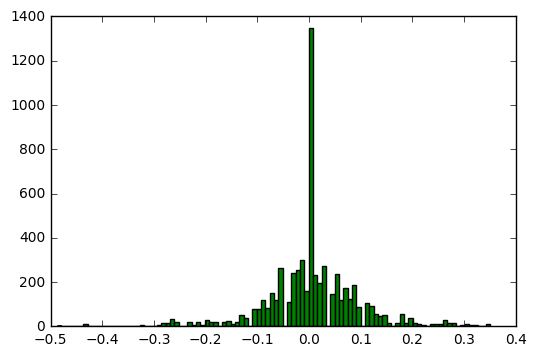

Zeros: 1168
Left: 2382
Right: 2612
Samples: 6162


In [19]:
num_bins = 100
# the histogram of the data
n, bins, patches = plt.hist(df.loc[:,'steering'], num_bins, facecolor='green')
plt.show()
print("Zeros:",(df.loc[:,'steering'] == 0.0).sum())
print("Left:",(df.loc[:,'steering'] < 0.0).sum())
print("Right:",(df.loc[:,'steering'] > 0.0).sum())
print("Samples:",len(df))

In [ ]:
import scipy.signal as signal
import scipy.interpolate as interpolate
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
     
     This method is based on the convolution of a scaled window with the signal.
     The signal is prepared by introducing reflected copies of the signal 
     (with the window size) in both ends so that transient parts are minimized
     in the begining and end part of the output signal.
     
     input:
         x: the input signal 
         window_len: the dimension of the smoothing window; should be an odd integer
         window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
             flat window will produce a moving average smoothing.
 
     output:
         the smoothed signal
         
     example:
 
     t=linspace(-2,2,0.1)
     x=sin(t)+randn(len(t))*0.1
     y=smooth(x)
     
     see also: 
     
     numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
     scipy.signal.lfilter
  
     TODO: the window parameter could be the window itself if an array instead of a string
     NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] 
     instead of just y.
     """ 
      
    #if x.ndim != 1:
    #    raise ValueError, "smooth only accepts 1 dimension arrays."
 
    #if x.size < window_len:
    #    raise ValueError, "Input vector needs to be bigger than window size."

    #if window_len<3:
    #    return x
        
    #if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
    #    raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
            
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
     
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y 

# First, design the Buterworth filter
#N  = 10    # Filter order
#rp = 1
#Wn = 0.05 # Cutoff frequency
#B, A = signal.butter(N, Wn, output='ba')
#B, A = signal.cheby1(N, rp, Wn)
 
# Second, apply the filter
#filtered_angles = signal.filtfilt(B,A, df.loc[:,'steering'])

a = df.loc[:,'steering'].astype('float')
b = smooth(a,window_len=17, window='flat').astype('float')

filtered_angles = b

#x = np.arange(0, len(df))
#y = df.loc[:,'steering']
#tck = interpolate.splrep(x,y)
#xnew = np.arange(0, len(df), 0.1)
#ynew = interpolate.splev(xnew,tck,der=0)

plt.figure(figsize=(25,10))
#plt.plot(df.loc[3000:4000,'steering'], 'b-')
#plt.plot(filtered_angles[3000:4000], 'r-')
plt.plot(a[1000:2000], 'b-')
#plt.plot(b, 'r-')
plt.show()
#print(a[3000:4000], b[3000:4000])

In [ ]:
# drop excess zero angles
from sklearn.utils import shuffle
df0 = df.query('steering == 0')
df1 = df.query('steering != 0')
df0 = shuffle(df0)
# use randomomly picked 1/3 of zeros
df0 = df0[:np.floor(len(df0)/3).astype('int')]
df = pd.concat([df0,df1])
#df = shuffle(df)
df = df.reset_index(drop=True)
print("Zeros:",(df.loc[:,'steering'] == 0.0).sum())
print("Left:",(df.loc[:,'steering'] < 0.0).sum())
print("Right:",(df.loc[:,'steering'] > 0.0).sum())
print("Samples:",len(df))

In [ ]:
def read_img(df, data_path, camera, nbr):
    data_file = data_path + '/' + df.loc[nbr,camera].strip()
    return mpimg.imread(data_file)
    
def preprocess_img(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #img = cv2.GaussianBlur(img,(3, 3), 0)
    #img = cv2.equalizeHist(img[45:135,25:295,1]) # take the luminance channel
    img = img[45:135,25:295,:] # take the luminance channel
    img = cv2.equalizeHist(img[:,:,1]) * .25 # take the luminance channel
    return img
    #return cv2.resize(img, (48,16), interpolation=cv2.INTER_AREA)
    
def norm(t, rel=False):
    if rel:
        tmin = t.min();
        tmax = t.max();
        return (t - tmin) / (tmax - tmin) - 0.5
    else:
        return t / 255.0 - 0.5

In [ ]:
nbr = 1150
img = read_img(df, data_path, 'center', nbr)
plt.imshow(img)

In [ ]:
img = preprocess_img(img)
img = norm(img)
print(-df.loc[nbr,'steering'])
print(img.shape)
print(img.mean())
plt.imshow(img, cmap='gray')

In [ ]:
x = 1
samples = []

for i in range(0,len(df)):
    if x > 0 and df.loc[i,'steering'] < 0:
        samples.append(i)
        x = -1
    if x < 0 and df.loc[i,'steering'] == 0:
        samples.append(i)
        x = 0
    if x == 0 and df.loc[i,'steering'] > 0:
        samples.append(i)
        x = 1

print(len(samples))

In [ ]:
# Plot 
plot_cols = 3
plot_rows = 5
    
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(20, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.5)

#for ax in axes.flat:
    # turn all axis plotting off  
#    ax.axis('off')
    
axes[0,0].set_title('Left')
axes[0,1].set_title('Straight')
axes[0,2].set_title('Right')

for ax, index in zip(axes.flat, samples):
    # add subplot
    ax.imshow(preprocess_img(read_img(df,data_path,'center', index)), cmap='gray')
    ax.text(1, 0, df.loc[index,'steering'], style='italic', bbox={'facecolor':'yellow' })
plt.show();

## Read and Preprocess Training Data


In [ ]:
mu = 0.0
sigma = 0.2
s = np.random.normal(mu, sigma, len(df))
print(s[0:10])

In [ ]:
# Read training data
from sklearn.utils import shuffle

X_train = np.empty((len(df)*3,90,270,1), dtype='float') # images
y_train = np.zeros(len(df)*3, dtype='float') # steering angle

imshape = X_train[0].shape

for i in range (0,len(df)):
    angle = df.loc[i,'steering']
    img = norm((preprocess_img(read_img(df,data_path,'center',i)))).astype('float')
    X_train[i*3] = img.reshape(imshape)
    if angle == 0.0:
        y_train[i*3] = s[i]
    else:
        y_train[i*3] = angle
    
    img2 = norm((preprocess_img(read_img(df,data_path,'right',i)))).astype('float')
    #X_train[i*2+1] = cv2.flip(img,1).reshape(imshape)
    X_train[i*3+1] = img2.reshape(imshape)
    y_train[i*3+1] = y_train[i*3] - 0.2

    img3 = norm((preprocess_img(read_img(df,data_path,'left',i)))).astype('float')
    #X_train[i*2+1] = cv2.flip(img,1).reshape(imshape)
    X_train[i*3+2] = img3.reshape(imshape)
    y_train[i*3+2] = y_train[i*3] + 0.2

shuffle(X_train, y_train)

print(X_train.min(), X_train.max())
print(X_train.mean(), X_train.std())
print(y_train.mean(), y_train.std())
print(len(X_train))


In [ ]:
num_bins = 100
n, bins, patches = plt.hist(y_train, num_bins, facecolor='green')
plt.show()
print("Zeros:",(y_train == 0.0).sum())
print("Left:",(y_train < 0.0).sum())
print("Right:",(y_train > 0.0).sum())

## Batch generator

In [15]:
def get_image_and_angle(dfx, data_path, index, pos=1, camera_corr=.25):
    """
    Read image data and get the steering angle corresponding the image 
    Angle is corrected, if the camera is left or right
    """
    camera = ['left', 'center', 'right']
    data_file = data_path + '/' + dfx.loc[index,camera[pos]].strip()
    img = mpimg.imread(data_file)
    angle = dfx.loc[index,'steering'] + (pos * -camera_corr + camera_corr)
    #print(data_file, angle)
    return img, angle

def get_shifted_image_and_angle(img, angle, shift=0):
    """
    Get a center shifted crop from an image - may be max 25 pixels left or right
    """
    img2 = img[45:135,25+shift:295+shift]
    angle2 = angle - 0.002 * shift
    return img2, angle2

def get_luminance_and_normalize(img, color_space='YCrCB'):
    """
    Convert image to YCrCb and take only luminance channel.
    Do histogram equalization in order to increase contrast
    Normalize values between [-0.5,0.5]
    """
    if color_space == 'YCrCb':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb) # change color plane
        img2 = cv2.equalizeHist(img[:,:,0]) # take the luminance channel
    if color_space == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # change color plane
        img2 = cv2.equalizeHist(img[:,:,1]) # take the saturation channel
    img3 = img2.astype('float') / 255.0 - 0.5 # normalize to [-0.5,0.5]
    shape = img3.shape
    return img3.reshape(shape[0],shape[1],1)

def get_cropped_image(dfx, data_path, index, pos=None):
    """
    Return a camera image (left, right or center) crop
    If pos (camera) == None, return a random crop from a random camera 
    """
    if (pos == None):
        pos = np.random.randint(3)
        shift = np.random.randint(-25,25)
    else:
        shift = 0
    img, angle = get_image_and_angle(dfx, data_path, index=index, pos=pos)
    img2, angle2 = get_shifted_image_and_angle(img, angle, shift)
    img3 = get_luminance_and_normalize(img2, color_space='HSV')
    #print(img3[30,30,0])
    return img3, angle2
    

In [6]:
from sklearn.utils import shuffle

def get_image(dfx, data_path, index, pos=None):
    return get_cropped_image(dfx, data_path, index=index, pos=pos)

def index_generator(dfx, batch_size):
    
    data_set_size = 3*len(dfx)
    i = 0 # data
    j = 0 # batch
    # array of images. there are three images (left, center, right) on each row
    iarray = [(x,y) for x in range(len(df)) for y in range(3)] # index array
    iarray = shuffle(iarray)
    
    while True:
        
        if i >= data_set_size:
            #print("Shuffle", i)
            iarray = shuffle(iarray) # shuffle index array every time we have used whole set of original images
            i = 0
        if j >= batch_size:
            j = 0

        yield iarray[i], j

        i = i + 1
        j = j + 1

def data_generator(dfx, batch_size, val=False):
    
    igen = index_generator(dfx, batch_size)
    X_batch = np.zeros( (batch_size, 90, 270, 1), dtype='float')
    y_batch = np.zeros( batch_size, dtype='float')

    while True:
        data_index, batch_index = next(igen)

        if not val: # not validation
            X, y = get_image(dfx, data_path, index=data_index[0], pos=data_index[1])
        else:
            X, y = get_image(dfx, data_path, index=data_index[0])
            
        X_batch[batch_index] = X
        y_batch[batch_index] = y

        if batch_index == batch_size - 1:
            yield X_batch, y_batch  


In [ ]:
def test():
    a = [(x,y) for x in range(3) for y in range(2)]
    print(a)
test()

In [13]:
# test
generator = data_generator(df, 256, val=False)
for i in range(0,3):
    print("generating...")
    X, y = next(generator)
    print(X.shape, y.shape)
    print(X.mean(), X.std())
    print(y.mean(), y.std())
 

generating...
(256, 90, 270, 1) (256,)
0.00888048633805 0.28490941755
0.00905858996094 0.223406922814
generating...
(256, 90, 270, 1) (256,)
0.00887060802973 0.28508502079
0.0154730232031 0.233078543376
generating...
(256, 90, 270, 1) (256,)
0.00893960111051 0.284891260715
0.0265747779609 0.229279431061


In [ ]:
# Plot 
def augment_image(img, angle):
    """
    Test: generate a batch of 11 different crops from same image
    """
    # first normalize the whole image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb) # change color plane
    img2 = cv2.equalizeHist(img[:,:,0]) # take the luminance channel
    img_arr = np.empty((12,90,270), dtype='float')
    angle_arr = np.empty(11, dtype='float')

    # generate 11 images from one source
    for i in range(0,11):
        img_arr[i], angle_arr[i] = get_shifted_image_and_angle(img2, angle, shift=(-25 + 5*i)) 

    return img_arr, angle_arr

def plot_augmented(img_arr, angle_arr):

    plot_cols = 3
    plot_rows = 4
    
    fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.5)

    for ax, img, angle in zip(axes.flat, img_arr, angle_arr):
        ax.imshow(img, cmap='gray')
        ax.text(1, 0, angle, style='italic', bbox={'facecolor':'yellow' })

In [ ]:
# Test shifting and angle change

dfy = df.query('steering == 0')
dfy = dfy.reset_index(drop=True)
angle = dfy.loc[0,'steering']
img, angle = get_image_and_angle(dfy,data_path, index=500, pos=0)
X, y = augment_image(img, angle)
plot_augmented(X, y)
plt.show();
print(angle)

## The Model

In [7]:
# NVIDIA convolutional neural network

from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten, Dropout, MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam

def nvidia_model():
    """
    Implementation of the 'NVIDIA CNN' from 'End to End Learning for Self-Driving Cars'
    (https://arxiv.org/pdf/1604.07316v1.pdf)
    
    Normalization of the input, part of the original architecture, is done outside of this function
    
    Also added max pooling and dropout after last convolution layer before flattening
    
    """
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2,2), input_shape=(90,270,1)))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.50))
    model.add(Flatten())
    model.add(Dense(100, W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dense(50, W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dense(10, W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    #model.add(Dropout(0.50))
    model.add(Dense(1, name='y_pred', W_regularizer=l2(0.01)))
    return model

model = nvidia_model()
modelname = 'nvidia'
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 43, 133, 24)   624         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 43, 133, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 65, 36)    21636       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 20, 65, 36)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [ ]:
# tiny convolutional neural network

from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten, Dropout, MaxPooling2D
from keras.optimizers import Adam

def tiny_model():
    """
    
    Normalization of the input, part of the original architecture, is done outside of this function
    
    """
    model = Sequential()
    model.add(Convolution2D(2, 3, 3, border_mode='valid', input_shape=(90,270,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.50))
    ##model.add(Convolution2D(2, 3, 3))
    ##model.add(Activation('relu'))
    ##model.add(MaxPooling2D(pool_size=(2,2)))
    ##model.add(Dropout(0.50))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1, name='y_pred'))
    return model

model = tiny_model()
modelname = 'tiny'
model.summary()

In [ ]:
https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

## Training the model

Should use Keras [fit_generator](https://keras.io/models/model/) here.

Train the model using fit generator

In [8]:
from keras.models import model_from_json

def model_save(path, name, epoch):
    """
    Save model file and weights after each epoch
    (Actually model is the same every time, but this is easier way to integrate to drive.py)
    """
    model_path = path + '/model'
    filename = model_path + '/' + name + '_' + str(epoch+1)
    model_file =   filename + '.json'
    weights_file = filename + '.h5'

    json_string = model.to_json()
    with open(model_file, 'w') as jfile:
        jfile.write(json_string)
    jfile.close()

    model.save_weights(weights_file)

In [9]:
from keras.callbacks import Callback

class LossHistory(Callback):
    name = "" # model name
    path = "" # project path

    def __init__(self, path, name):
        self.path = path
        self.name = name
    def on_epoch_end(self, epoch, logs={}):
        model_save(self.path, self.name, epoch)
        #print("Model saved")
        # shuffle input after each epoch
    def on_batch_end(self, batch, logs={}):
        self.batch = 0


In [ ]:
# Compile and train the model here.

model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])

nb_epochs = 5
batch_size = 128
history = LossHistory(project_path, modelname)

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epochs, verbose=1, validation_data=None, callbacks=[history])

In [16]:
# Compile and train the model here.
print ("Training model", modelname)
model.compile(loss='mse', optimizer=Adam(), metrics=['mean_absolute_error'])
history = LossHistory(project_path, modelname)
model.fit_generator(data_generator(df, batch_size=256, val=False), 
                              samples_per_epoch = 256*4*18, 
                              nb_epoch=25, 
                              verbose=1,
                              validation_data=data_generator(df,batch_size=256, val=True),
                              nb_val_samples=256*4*4,
                              callbacks=[history])

Training model nvidia
Epoch 1/25
18432/18432 [==============================] - 313s - loss: 0.4076 - mean_absolute_error: 0.0816 - val_loss: 0.2378 - val_mean_absolute_error: 0.1370

Save the model and weights for validation

In [ ]:
print(json_string)

Grayscale, luminance channel, normalized
1. tiny model, 16x48x1 pixel, zero samples reduced to 1/3, 128/3, acc 0.2830, cannot handle first turn
2. nvidia model, same images, same reduction, 128/3, acc 0.2830,  goes to left before the bridge
3. tiny model, same px, all images, 128/3, acc 0.5430, better, cannot handle the bridge or left turn after brigde
4. tiny model, same px, all images, 128/6, acc 0.5430, better, cannot handle the bridge, more unstable than previous
5. nvidia, same px, all images, 128/3, acc 0.5432, pretty good until the left turn after the bridge

Window size and rendering quality has effect on the steering accuracy. Too detailed rendering -> worse.

6. tiny model, same px, all images, 128/3, acc 0.5432, HSV S-channel. Not good -> reverted to Y-channel
7. tiny model, same px, add flipped images from non-zero steering angle, 128/5, acc 0.3720, not good
8. nvidia model, same px, add flipped images, 128/5, acc 0.3720, not good

Forget image flipping? Generate new data some other way?

Adding dropout to tiny
Adding conv layer to tiny
Changing kernel size in nvidia (3x3 -> 1x1) -> not successful

Tiny: Too many epochs (5!) -> overfitting, 2 is much better

Going to Try 100x300 px images

Flip all! Not much help

Add all left camera images without correction: right away out from right
Add all right camera images without correction: right away out from left. Surprise!

Add both right and left, reduce zero images, no angle correction, mean erro 0.0539 -> out after bridge

Add both right and left, reduce zero images, angle correction +/- 0.2, mean error,



pixel correction: 0,004 (0.1degree), side camera correction 0.25 (6.25 degrees), 20K samples -> passes the track. outside yellow lines after the bridge, cannot go straight

Changing to HSV color space and using S-plane fixed the turn after the bridge.